In [1]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# global variables
bg = None
left,top,right,bottom = 0,0,0,0

def run_avg(image, aWeight):
    global bg
    # initialize the background
    if bg is None:
        bg = image.copy().astype("float")
        return

    # compute weighted average, accumulate it and update the background
    cv2.accumulateWeighted(image, bg, aWeight)

In [3]:

def segment(image, threshold=30):
    global bg
    # find the absolute difference between background and current frame
    diff = cv2.absdiff(bg.astype("uint8"), image)

    # threshold the diff image so that we get the foreground
    thresholded = cv2.threshold(diff,
                                threshold,
                                255,
                                cv2.THRESH_BINARY)[1]

    # get the contours in the thresholded image
    (cnts, _) = cv2.findContours(thresholded.copy(),
                                 cv2.RETR_EXTERNAL,
                                 cv2.CHAIN_APPROX_SIMPLE)

    # return None, if no contours detected
    if len(cnts) == 0:
        return
    else:
        # based on contour area, get the maximum contour which is the hand
        segmented = max(cnts, key=cv2.contourArea)
        return (thresholded, segmented)

In [4]:
bg = None

def data_generate(selectroi=True):
    # initialize weight for running average
    aWeight = 0.5
    global left
    global right
    global top
    global bottom
    # get the reference to the webcam
    if selectroi:
        cap = cv2.VideoCapture(0)
        (grabbed, frame) = cap.read()
        frame = cv2.flip(frame, 1)
        # region of interest (ROI) coordinates
        r = cv2.selectROI(frame)
        left,top,right,bottom= int(r[0]+r[2]), int(r[1]), int(r[0]), int(r[1]+r[3])
        cap.release()
        cv2.destroyAllWindows()
    else:
        left,top,right,bottom=640,95,353,433
    
    camera=cv2.VideoCapture(0)

    # initialize num of frames
    num_frames = 0
    image_num = 0

    start_recording = False

    # keep looping, until interrupted
    while(True):
        # get the current frame
        (grabbed, frame) = camera.read()
        if (grabbed == True):

            # resize the frame
            frame = imutils.resize(frame, width=700)

            # flip the frame so that it is not the mirror view
            frame = cv2.flip(frame, 1)

            # clone the frame
            clone = frame.copy()

            # get the height and width of the frame
            (height, width) = frame.shape[:2]

            # get the ROI
            roi = frame[top:bottom, right:left]

            # convert the roi to grayscale and blur it
            gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            gray = cv2.GaussianBlur(gray, (7, 7), 0)

            # to get the background, keep looking till a threshold is reached
            # so that our running average model gets calibrated
            if num_frames < 30:
                run_avg(gray, aWeight)
                print(num_frames)
            else:
                # segment the hand region
                hand = segment(gray)

                # check whether hand region is segmented
                if hand is not None:
                    # if yes, unpack the thresholded image and
                    # segmented region
                    (thresholded, segmented) = hand

                    # draw the segmented region and display the frame
                    cv2.drawContours(
                        clone, [segmented + (right, top)], -1, (0, 0, 255))
                    if start_recording:

                        # Mention the directory in which you wanna store the images followed by the image name
                        cv2.imwrite("DATASET_DL/BLANK/" +
                                    str(image_num) + '.png', thresholded)
                        image_num += 1
                    cv2.imshow("Thesholded", thresholded)

            # draw the segmented hand
            cv2.rectangle(clone, (left, top), (right, bottom), (0, 255, 0), 2)

            # increment the number of frames
            num_frames += 1

            # display the frame with segmented hand
            cv2.imshow("Video Feed", clone)

            # observe the keypress by the user
            keypress = cv2.waitKey(1) & 0xFF

            # if the user pressed "q", then stop looping
            if keypress == ord("q") or image_num > 500:
                break

            if keypress == ord("s"):
                start_recording = True

        else:
            print("[Warning!] Error input, Please check your(camra Or video)")
            break
    # free up memory
    camera.release()
    cv2.destroyAllWindows()
data_generate(False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [4]:
from PIL import Image

def resizeImage(imageName):
    basewidth = 100
    img = Image.open(imageName)
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    img.save(imageName)

for i in range(0, 501):
    # Mention the directory in which you wanna resize the images followed by the image name
    resizeImage(("DATASET_DL/DOWN/" +str(i) + '.png'))

In [5]:
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d,max_pool_2d
from tflearn.layers.core import input_data,dropout,fully_connected
from tflearn.layers.estimator import regression
import numpy as np
import cv2
from sklearn.utils import shuffle

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [22]:
loadedImages = []
for i in range(0, 301):
    image = cv2.imread("DATASET_DL/DOWN/" +str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    loadedImages.append(gray_image.reshape(100, 117, 1))

#Load Images From Palm
for i in range(0, 301):
    image = cv2.imread("DATASET_DL/UP/" +str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    loadedImages.append(gray_image.reshape(100, 117, 1))
    
#Load Images From Fist
for i in range(0, 301):
    image = cv2.imread("DATASET_DL/RIGHT/" +str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    loadedImages.append(gray_image.reshape(100, 117, 1))
                       
for i in range(0, 301):
    image = cv2.imread("DATASET_DL/LEFT/" +str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    loadedImages.append(gray_image.reshape(100, 117, 1)) 

for i in range(0, 301):
    image = cv2.imread("DATASET_DL/BLANK/" +str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    loadedImages.append(gray_image.reshape(100, 117, 1)) 

In [23]:

outputVectors = []
for i in range(0, 301):
    outputVectors.append([1, 0, 0, 0,0])#down

for i in range(0, 301):
    outputVectors.append([0, 1, 0,0,0])#up

for i in range(0, 301):
    outputVectors.append([0, 0, 1,0,0])#right

for i in range(0, 301):
    outputVectors.append([0, 0, 0,1,0])#left
    
for i in range(0, 301):
    outputVectors.append([0, 0, 0,0,1])#blank

In [24]:
testImages = []
for i in range(301,501):
    image = cv2.imread("DATASET_DL/DOWN/" +str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    testImages.append(gray_image.reshape(100, 117, 1))

#Load Images From Palm
for i in range(301,501):
    image = cv2.imread("DATASET_DL/UP/" +str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    testImages.append(gray_image.reshape(100, 117, 1))
    
#Load Images From Fist
for i in range(301,501):
    image = cv2.imread("DATASET_DL/RIGHT/" +str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    testImages.append(gray_image.reshape(100, 117, 1))
                       
for i in range(301,501):
    image = cv2.imread("DATASET_DL/LEFT/" +str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    testImages.append(gray_image.reshape(100, 117, 1)) 
    
for i in range(301,501):
    image = cv2.imread("DATASET_DL/BLANK/" +str(i) + '.png')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    testImages.append(gray_image.reshape(100, 117, 1)) 
    
    
    

testVectors = []
for i in range(301,501):
    testVectors.append([1, 0, 0, 0,0])#down

for i in range(301,501):
    testVectors.append([0, 1, 0,0,0])#up

for i in range(301,501):
    testVectors.append([0, 0, 1,0,0])#right

for i in range(301,501):
    testVectors.append([0, 0, 0,1,0])#left
    
for i in range(301,501):
    testVectors.append([0, 0, 0,0,1])#blank

In [25]:
tf.compat.v1.reset_default_graph()
convnet=input_data(shape=[None,100, 117, 1],name='input')
convnet=conv_2d(convnet,32,2,activation='relu')
convnet=max_pool_2d(convnet,2)
convnet=conv_2d(convnet,64,2,activation='relu')
convnet=max_pool_2d(convnet,2)

convnet=conv_2d(convnet,128,2,activation='relu')
convnet=max_pool_2d(convnet,2)

convnet=conv_2d(convnet,256,2,activation='relu')
convnet=max_pool_2d(convnet,2)

convnet=conv_2d(convnet,256,2,activation='relu')
convnet=max_pool_2d(convnet,2)

convnet=conv_2d(convnet,128,2,activation='relu')
convnet=max_pool_2d(convnet,2)

convnet=conv_2d(convnet,64,2,activation='relu')
convnet=max_pool_2d(convnet,2)

convnet=fully_connected(convnet,1000,activation='relu')
convnet=dropout(convnet,0.75)

convnet=fully_connected(convnet,5,activation='softmax')

convnet=regression(convnet,optimizer='adam',learning_rate=0.001,loss='categorical_crossentropy',name='regression')

model=tflearn.DNN(convnet,tensorboard_verbose=0)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
loadedImages, outputVectors = shuffle(loadedImages, outputVectors, random_state=0)

# Train model
model.fit(loadedImages, outputVectors, n_epoch=10,
           validation_set = (testImages, testVectors),
           snapshot_step=100, show_metric=True, run_id='convnet_coursera')



Training Step: 239  | total loss: 0.11085 | time: 12.499s
| Adam | epoch: 010 | loss: 0.11085 - acc: 0.9907 -- iter: 1472/1505
Training Step: 240  | total loss: 0.09988 | time: 15.153s
| Adam | epoch: 010 | loss: 0.09988 - acc: 0.9916 | val_loss: 0.00311 - val_acc: 1.0000 -- iter: 1505/1505
--


In [27]:
model.save("Models/GestureRecogModel.tfl")

INFO:tensorflow:D:\Work_Files\Gesture_Controlled_Gaming\Models\GestureRecogModel.tfl is not in all_model_checkpoint_paths. Manually adding it.


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tflearn
from tflearn.layers.conv import conv_2d,max_pool_2d
from tflearn.layers.core import input_data,dropout,fully_connected
from tflearn.layers.estimator import regression
import numpy as np
from PIL import Image
import cv2
import imutils
import sys
import pyautogui as pyg
# global variables
bg = None

def resizeImage(image):
    basewidth = 100
    img = Image.fromarray(image)
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    return img

def run_avg(image, aWeight):
    global bg
    # initialize the background
    if bg is None:
        bg = image.copy().astype("float")
        return

    # compute weighted average, accumulate it and update the background
    cv2.accumulateWeighted(image, bg, aWeight)

def segment(image, threshold=25):
    global bg
    # find the absolute difference between background and current frame
    diff = cv2.absdiff(bg.astype("uint8"), image)

    # threshold the diff image so that we get the foreground
    thresholded = cv2.threshold(diff,
                                threshold,
                                255,
                                cv2.THRESH_BINARY)[1]

    # get the contours in the thresholded image
    (cnts, _) = cv2.findContours(thresholded.copy(),
                                    cv2.RETR_EXTERNAL,
                                    cv2.CHAIN_APPROX_SIMPLE)

    # return None, if no contours detected
    if len(cnts) == 0:
        return
    else:
        # based on contour area, get the maximum contour which is the hand
        segmented = max(cnts, key=cv2.contourArea)
        return (thresholded, segmented)

    

    
    
def main():
    
    
    # Set Player = True in order to use this script for the VLC video player
    player = False

    # This variable is True when we press a key and False when there is no detection.
    # It's only used in the video Player
    status = False
    key=None
    
    # initialize weight for running average
    aWeight = 0.5
    
    # get the reference to the webcam
    camera = cv2.VideoCapture(0)

    # region of interest (ROI) coordinates
    left,top,right,bottom=640,95,353,433

    # initialize num of frames
    num_frames = 0
    start_recording = False

    # keep looping, until interrupted
    while(True):
        try:
            # get the current frame
            (grabbed, frame) = camera.read()

            # resize the frame
            frame = imutils.resize(frame, width = 700)

            # flip the frame so that it is not the mirror view
            frame = cv2.flip(frame, 1)

            # clone the frame
            clone = frame.copy()

            # get the height and width of the frame
            (height, width) = frame.shape[:2]

            # get the ROI
            roi = frame[top:bottom, right:left]

            # convert the roi to grayscale and blur it
            gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            gray = cv2.GaussianBlur(gray, (7, 7), 0)

            # to get the background, keep looking till a threshold is reached
            # so that our running average model gets calibrated
            if num_frames < 30:
                run_avg(gray, aWeight)
            else:
                # segment the hand region
                hand = segment(gray)

                # check whether hand region is segmented
                if hand is not None:
                    # if yes, unpack the thresholded image and
                    # segmented region
                    (thresholded, segmented) = hand

                    # draw the segmented region and display the frame
                    cv2.drawContours(clone, [segmented + (right, top)], -1, (0, 0, 255))
                    if start_recording:
                        predimg = np.array(resizeImage(thresholded))
                        plt.imshow(predimg)
                        prediction=model.predict([predimg.reshape(100, 117, 1)])
                        label = np.argmax(model.predict([predimg.reshape(100, 117, 1)]))
                        conf=np.amax(prediction) / (prediction[0][0] + prediction[0][1] + prediction[0][2]+prediction[0][3]+prediction[0][4])
                        

                        if label!=4 and conf>0.9:

                            if label==2:

                                key = 'right'
                                if player and not status:
                                    pyg.hotkey('ctrl', 'right') 
                                    status = True

                            elif label==3:

                                key = 'left'               
                                if player and not status:
                                    pyg.hotkey('ctrl', 'left')
                                    status = True

                            elif label==1:

                                key = 'up'
                                if player and not status:
                                    pyg.press('space')
                                    status = True

                            elif label==0:
                                key = 'down'

                            # Check if we're playing a game then press the required key
                            if key is not None and player == False:                
                                    pyg.press(key)            


                        # If there wasn't a detection then the status is made False
                        else:
                            status = False
                

#                         showStatistics(label, confidence)####################
#                     cv2.imshow("Thesholded", thresholded)###################

            # draw the segmented hand
            cv2.rectangle(clone, (left, top), (right, bottom), (0,255,0), 2)

            # increment the number of frames
            num_frames += 1

            # display the frame with segmented hand
            cv2.imshow("Video Feed", clone)
            # observe the keypress by the user
            keypress = cv2.waitKey(1) & 0xFF

            # if the user pressed "q", then stop looping
            if keypress == ord("q"):
                camera.release()
                cv2.destroyAllWindows()
                break
            if keypress == ord("s"):
                start_recording = True
        
        except KeyboardInterrupt:
            print('Releasing the Camera and exiting since the program was stopped')
            camera.release()
            cv2.destroyAllWindows()
            sys.exit()

def showStatistics(predictedClass, confidence):

    textImage = np.zeros((300,512,3), np.uint8)
    className = ""

    if predictedClass == 0:
        className = "Down"
    elif predictedClass == 1:
        className = "Up"
    elif predictedClass == 2:
        className = "Right"
    elif predictedClass==3:
        className='Left'
    elif predictedClass==4:
        className='X'

    cv2.putText(textImage,"Pedicted Class : " + className, 
    (30, 30), 
    cv2.FONT_HERSHEY_SIMPLEX, 
    1,
    (255, 255, 255),
    2)

    cv2.putText(textImage,"Confidence : " + str(confidence * 100) + '%', 
    (30, 100), 
    cv2.FONT_HERSHEY_SIMPLEX, 
    1,
    (255, 255, 255),
    2)
    cv2.imshow("Statistics", textImage)




# Model defined
tf.compat.v1.reset_default_graph()
convnet=input_data(shape=[None,100, 117, 1],name='input')
convnet=conv_2d(convnet,32,2,activation='relu')
convnet=max_pool_2d(convnet,2)
convnet=conv_2d(convnet,64,2,activation='relu')
convnet=max_pool_2d(convnet,2)

convnet=conv_2d(convnet,128,2,activation='relu')
convnet=max_pool_2d(convnet,2)

convnet=conv_2d(convnet,256,2,activation='relu')
convnet=max_pool_2d(convnet,2)

convnet=conv_2d(convnet,256,2,activation='relu')
convnet=max_pool_2d(convnet,2)

convnet=conv_2d(convnet,128,2,activation='relu')
convnet=max_pool_2d(convnet,2)

convnet=conv_2d(convnet,64,2,activation='relu')
convnet=max_pool_2d(convnet,2)

convnet=fully_connected(convnet,1000,activation='relu')
convnet=dropout(convnet,0.75)

convnet=fully_connected(convnet,5,activation='softmax')

convnet=regression(convnet,optimizer='adam',learning_rate=0.001,loss='categorical_crossentropy',name='regression')

model=tflearn.DNN(convnet,tensorboard_verbose=0)

# Load Saved Model
model.load("Models/GestureRecogModel.tfl")



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Restoring parameters from D:\Work_Files\Gesture_Controlled_Gaming\Models\GestureRecogModel.tfl


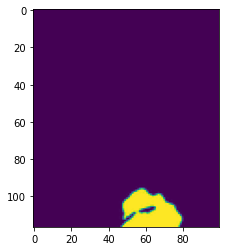

In [7]:
main()

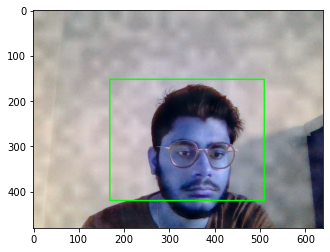

In [3]:
camera = cv2.VideoCapture(0)
grab,frame=camera.read()
r = cv2.selectROI(frame)
cv2.rectangle(frame, (int(r[0]+r[2]), int(r[1])), (int(r[0]), int(r[1]+r[3])), (0,255,0), 2)
plt.imshow(frame)
camera.release()
cv2.destroyAllWindows()

In [23]:
camera.release()
cv2.destroyAllWindows()

In [10]:
bottom

433

In [11]:
left

640

In [12]:
right

353

In [13]:
top

95